In [4]:
import PVGeo
import numpy as np
import pandas as pd
import pyvista

print('NumPy Version: %s' % np.__version__)
print('PVGeo Version: %s' % PVGeo.__version__)
print('pyvista Version: %s' % pyvista.__version__)

NumPy Version: 1.18.1
PVGeo Version: 2.1.0
pyvista Version: 0.24.1


# Welcome to PVGeo

Thanks for checking out this notebook! We hope this provides some insight on how you can get started using PVGeo in your Python (3) routines. Let's get started!

At the top of this notebook, we import `numpy` and `PVGeo` and display the current environment's version of thos packages. Since PVGeo is still in its infancy, feature development is rapid and new versions get deployed very often. With this in mind, be sure to keep the PVGeo in your environment up to date! 

A simple way to update PVGeo from your Jupyter Notebook:

```py
!pip install --upgrade PVGeo
```

We have placed some data files in the `data/` directory for you to use. The remainder of this notebook will explore a few examples loading, filtering, and writing out data using a combination of `PVGeo` and `vista`


## 1. Introduction to PVGeo

### What is PVGeo?

- **Python** package for 3D/4D geovisualization.
- Create compelling and **integrated visualizations**.
- Built upon **VTK**, a scalable and well-maintained visualization library.
- Extends geovisualization into **ParaView**, **VTK.js**, and **Virtual Reality**.
- **Open-source** and automatically deployed.

![expansion-diagram](./images/expansion-diagram.png)


### Abstract

PVGeo is an open-source Python package for geoscientific visualization and analysis, harnessing an already powerful software platform: the Visualization Toolkit (VTK) and its front-end application, [ParaView](http://paraview.org). The VTK software platform is well-maintained, contains an expansive set of native functionality, and provides a robust foundation for scientific visualization, yet the development of tools compatible for geoscience data and models has been limited. As a software extension package to VTK and ParaView, PVGeo addresses the lack of geoscientific compatibility by creating a framework for geovisualization. This framework is a set of tools for visually integrating geoscience data and models directly within ParaView's graphical user interface, simplifying the required routines to make compelling visualizations of geoscientific datasets. PVGeo aims to make the process of importing data into ParaView simple and fluid for users while providing a guide for contributions avoiding the typical, ambitious programming endeavor of building ParaView plugins. The PVGeo package is available for download on PyPI (pip install PVGeo), [documented online](http://pvgeo.org), and [open-source on GitHub](https://github.com/OpenGeoVis/PVGeo) for community-driven development.


### PVGeo Resources

- [Brief demo page](http://demo.pvgeo.org)
- [Slcak community](http://slack.pvgeo.org)
- [The code](https://github.com/OpenGeoVis/PVGeo)
- [Use examples in ParaView](http://pvgeo.org/examples/about-examples/)
- [Nitty gritty code docs](http://docs.pvgeo.org)
- [Vimeo video examples](https://vimeo.com/user82050125)


### Take aways

- Join [PVGeo on Slack](http://slack.pvgeo.org)
    - The slack workspace is for anyone using ParaView for geovisualization
- [Presentation at AGU in December 2018](http://pvgeo.org/overview/agu-2018/)
- ParaView natively extends into VR (dynamically linked)
- VTK and ParaView are incredibly scalable
- PVGeo is Python based and open-source


# Filtering Data with PVGeo

## Table to Points

Let's go ahead and load a simple file that has XYZ coordinates and a boolean array for fault presence. This point cloud makes some sort of regular grid, but we have forgotten the deatials of the cell spacings and local coordinate rotations.

We will read in this data with pandas and send it to the PVGeo filter `PointsToPolyData` to create a `vista.PolyData` object (essentially a point cloud).

In [3]:
import pandas as pd
points = pd.read_csv('data/fault_points.csv')
points[0:2]

,X,Y,Z,Fault
0,326819.497,4407450.636,1287.5,0
1,326834.340,4407470.753,1287.5,0


In [5]:
# Convert to vista.PolyData (assumes first this three columns are XYZ)
vtkpoints = PVGeo.points_to_poly_data(points)
vtkpoints

PolyData (0x2cdcc9dae88)
  N Cells:	499200
  N Points:	499200
  X Bounds:	3.268e+05, 3.302e+05
  Y Bounds:	4.406e+06, 4.410e+06
  Z Bounds:	1.250e+01, 1.288e+03
  N Arrays:	1

Note that we have a `vista.PolyData` object now which allows us to do all types of immediate plotting of our data. First, lets threshold our points as the point cloud has a bunch of zeros and ones throughout the dataspace to describe the presence of a fault. 

To threshold the points, we call the `threshold` filter directly on our data object and pass the thresholding value.

We can then plot the result by calling the `plot` function. (Note: change the `notebook` parameter to `False` for an interactive window)

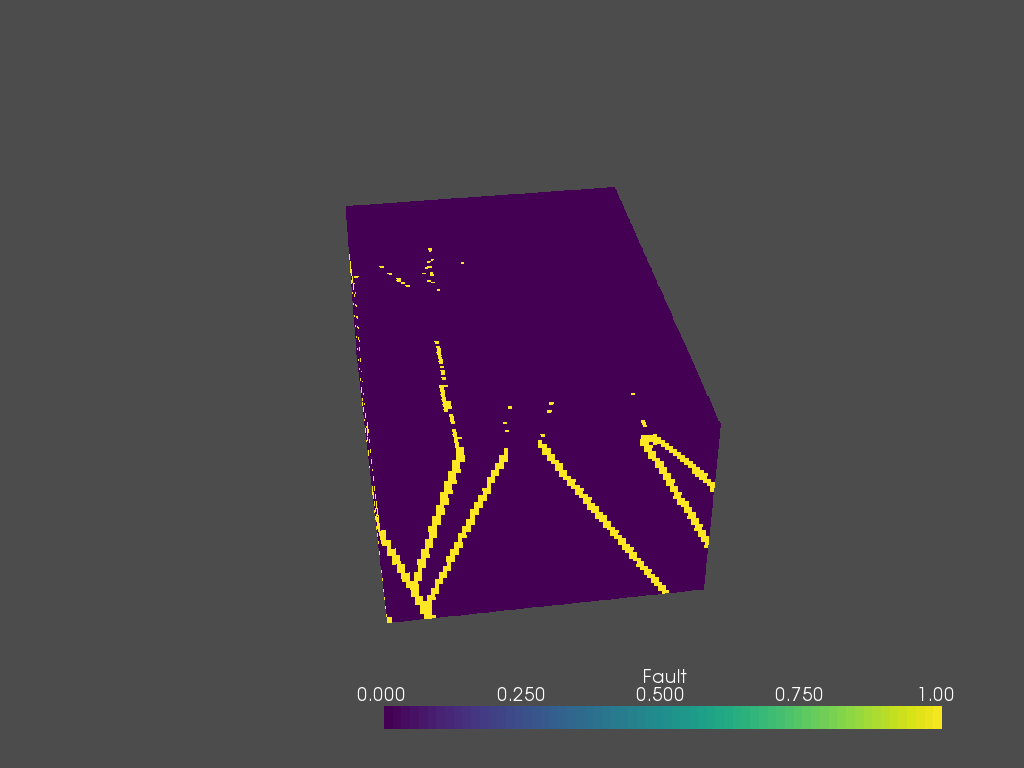

In [6]:
vtkpoints.plot(clim=[0,1])

## Points to Voxelized Volume

The above figure is pretty cools! But its a point cloud which means out filtering options are pretty limited. Fortunately, we know that the point cloud represents some sort of regularlized gridded volume of data and `PVGeo` has a filter to recover that volume. This will allow further volumetric operations can be performed with other `PVGeo` or VTK filters.

Remember that these points are rotated and we do not know the cell sizes... this is okay! The `VoxelizePoints` filter from PVGeo will handle the recovory of the coordinate rotation and grid our data **without** running an interpolation scheme. The `VoxelizePoints` filter assumes that the points are structure on some rotated XY-plane with regular cell spacings and does the rest on its own! Check out [`VoxelizePoints` code docs](http://docs.pvgeo.org/en/latest/content/PVGeo/filters/voxelize.html#voxelize-points) for more details.

In [7]:
# The full pipeline method
print('Voxelizing... ', end='')
voxelizer = PVGeo.filters.VoxelizePoints()
#print(dir(voxelizer))
grid = voxelizer.apply(vtkpoints)
print('done.')

# Output the results
print('Recovered Angle (deg.): %.3f' % voxelizer.get_recovered_angle())
print('Recovered Cell Sizes: (%.2f, %.2f, %.2f)' % voxelizer.get_spacing())
grid

Voxelizing...done.
Recovered Angle (deg.): 53.550
Recovered Cell Sizes: (25.00, 25.00, 25.00)


UnstructuredGrid (0x2cdd0bcd168)
  N Cells:	499200
  N Points:	524064
  X Bounds:	3.268e+05, 3.302e+05
  Y Bounds:	4.406e+06, 4.410e+06
  Z Bounds:	0.000e+00, 1.300e+03
  N Arrays:	3

In [8]:
# A simpler method to voxelize
# grid = PVGeo.filters.VoxelizePoints().Apply(vtkpoints)
# grid

Now we have a volumetric dataset in the form of a `vista.UnstructuredGrid`! This means we can perform volumetric operations like slicing, clipping, and the works!

## Slice Volumetric Data

Now lets use one of `vista`'s filters to create slices of the thresholded dataset. Specifically, we are using the `slice_orthogonal` filter that will create 3 orthogonal slices through a data volume.

In [9]:
slices = grid.slice_orthogonal()
slices

MultiBlock (0x2cdda2a03a8)
  N Blocks:	3
  X Bounds:	326804.336, 330185.260
  Y Bounds:	4406253.954, 4409862.606
  Z Bounds:	0.000, 1300.000

# Integrated Visualization 

Up to this point, we have filtered a single dataset and plotted the result by itself; this is usefult, but what if we have all kinds of data we want to throw into one rendering environment? Its pretty easy:

For a simple case, see below. Otherwise, move on to our next notebooks that run through bigger datasets and show how to combine data feature like a 3D model with topography surfaces, well trajectories, and more!


In [10]:
clip = grid.clip(normal='x').clip(normal='-y').threshold(0.5)

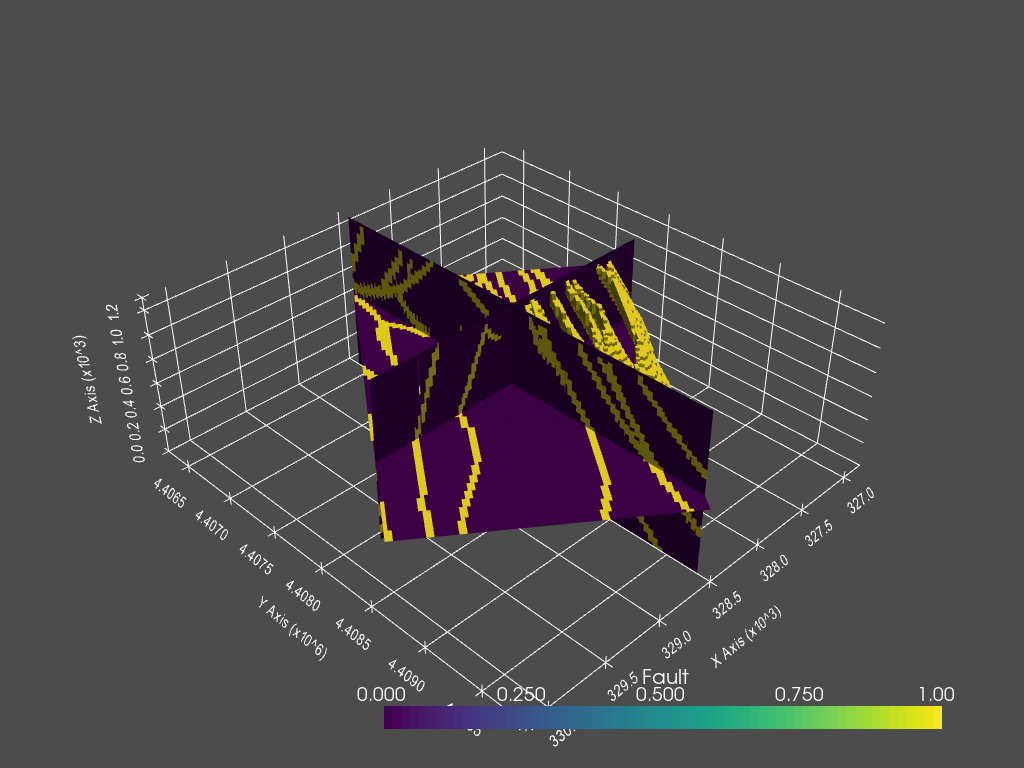

In [14]:
p = pyvista.Plotter()
p.add_mesh(slices)
p.add_mesh(clip)
p.show_grid()
p.show()